# CC Scheme

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from obspy import UTCDateTime, read_inventory
import os
import xcorr

In [2]:
%matplotlib notebook

In [3]:
client = xcorr.Client(sds_root='/Users/psmets/Documents/Research/_data/WaveformArchive')

In [4]:
# general parameters
sampling_rate = 50.
window_length = 86400. # 24h
window_overlap = 21./24. # 3h shift
clip_lag = (0., 9*3600.) # s
poi = {'name': 'MVC', 'latitude': -25.887, 'longitude': -177.188, 'elevation': 0., 'local_depth': 132.}

attrs = {
    'title': 'Monowai Volcanic Centre',
    'institution': 'Delft University of Technology, Department of Geoscience and Engineering',
    'author': 'Pieter Smets - P.S.M.Smets@tudelft.nl',
    'source': 'CTBTO/IMS hydroacoustic data and IRIS/USGS seismic data',
}

# stream preprocess operations (sequential!)
preprocess = {
    'BHZ': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {'output': 'VEL'}),
        ('filter', { 'type': 'highpass', 'freq': 3. }),
        ('interpolate', {'sampling_rate': 50, 'method':'lanczos', 'a':20 }),
        ('filter', { 'type': 'lowpass', 'freq': 20. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', { 'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
    ],
    'BHR': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {'output': 'VEL'}),
        ('rotate', {'method':'->ZNE'}),
        ('rotate', {'method':'NE->RT', 'back_azimuth':250.39 }),
        ('select', {'channel':'BHR'}),
        ('filter', { 'type': 'highpass', 'freq': 3. }),
        ('interpolate', {'sampling_rate': 50, 'method':'lanczos', 'a':20 }),
        ('filter', { 'type': 'lowpass', 'freq': 20. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', { 'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
    ],
    'EDH': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        # ('remove_sensitivity', {}),
        ('remove_response', {}),
        ('filter', { 'type': 'bandpass', 'freqmin': 3., 'freqmax': 20. }),
        ('decimate', { 'factor': 5 }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', {'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
    ],
}

In [5]:
pairs = [
    'IM.H10N1..EDH-IU.RAR.10.BHZ',
    'IM.H10N1..EDH-IU.RAR.10.BHR',
    'IM.H03S1..EDH-IU.RAR.10.BHZ',
    'IM.H03S1..EDH-IU.RAR.10.BHR',
]
times = pd.date_range('2015-01-15', '2015-01-18', freq='1D')

# inv = xcorr.util.get_pair_inventory(pairs, read_inventory('../data/Monowai_new.xml'), times)
inv = read_inventory('../data/Monowai_new.xml')

# fig = inv.plot(color=0., projection='local')

## Correlate one day of data

In [6]:
pp_sens = preprocess.copy()
pp_sens['EDH'] = [
    ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
    ('filter', {'type':'highpass','freq':.05}),
    ('detrend', { 'type': 'demean' }),
    ('remove_sensitivity', {}),
    ('filter', { 'type': 'bandpass', 'freqmin': 3., 'freqmax': 20. }),
    ('decimate', { 'factor': 5 }),
    ('trim', {}),
    ('detrend', { 'type': 'demean' }),
    ('taper', {'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
]
pp_resp = preprocess.copy()
pp_resp['EDH'] = [
    ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
    ('filter', {'type':'highpass','freq':.05}),
    ('detrend', { 'type': 'demean' }),
    ('remove_response', {}),
    ('filter', { 'type': 'bandpass', 'freqmin': 3., 'freqmax': 20. }),
    ('decimate', { 'factor': 5 }),
    ('trim', {}),
    ('detrend', { 'type': 'demean' }),
    ('taper', {'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
]

In [7]:
pair = pairs[0]
time = times[0]

ds_resp = xcorr.init(
    pair=pair,
    starttime=time,
    endtime=time + pd.offsets.DateOffset(1), 
    attrs=attrs,
    preprocess=pp_resp, 
    sampling_rate=sampling_rate, 
    window_length=window_length, 
    window_overlap=window_overlap, 
    clip_lag=clip_lag,
    unbiased_cc=False,
    inventory=inv,
    stationary_poi=poi,
)

ds_sens = xcorr.init(
    pair=pair,
    starttime=time,
    endtime=time + pd.offsets.DateOffset(1), 
    attrs=attrs,
    preprocess=pp_sens, 
    sampling_rate=sampling_rate, 
    window_length=window_length, 
    window_overlap=window_overlap, 
    clip_lag=clip_lag,
    unbiased_cc=False,
    inventory=inv,
    stationary_poi=poi,
)

In [8]:
xcorr.process(ds_resp, inventory=inv, client=client, test_run=True)
xcorr.process(ds_sens, inventory=inv, client=client, test_run=True)

IM.H10N1..EDH-IU.RAR.10.BHZ 2015-01-15T00:00:00: Waveforms. CC. Done.
IM.H10N1..EDH-IU.RAR.10.BHZ 2015-01-15T00:00:00: Waveforms. CC. Done.


<IPython.core.display.Javascript object>


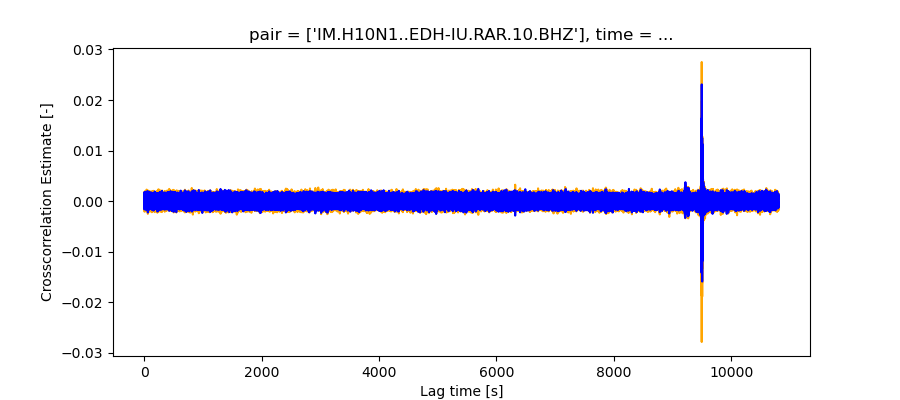

In [9]:
plt.figure(figsize=[9,4])
ds_resp.cc.loc[{'time': ds_resp.time[0]}].plot.line(x='lag',add_legend=False,color='orange')
ds_sens.cc.loc[{'time': ds_sens.time[0]}].plot.line(x='lag',add_legend=False,color='blue')

In [ ]:
psd_resp = xcorr.signal.psd(ds_resp.cc.where((ds_resp.lag>9400)&(ds_resp.lag<9600)), 2.)

In [11]:
plt.figure()
psd.loc[{'pair': psd_resp.pair[0], 'time': psd_resp.time[0]}].plot(x='lag')
plt.xlim(9400, 9600)

<IPython.core.display.Javascript object>